## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
sns.set()

# Dataset at https://ieee-dataport.org/open-access/minifrance

In [2]:
import glob
import os
site_1_X = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nantes_Saint-Nazaire/BDORTHO", "*tif"))))
site_1_Y = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nantes_Saint-Nazaire/UrbanAtlas", "*tif"))))
site_2_X = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nice/BDORTHO", "*tif"))))
site_2_Y = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nice/UrbanAtlas", "*tif"))))

## Load Tiff File

In [3]:
def loadTiff(filenameX, filenameY):
    tileX = rasterio.open(filenameX).read()
    tileX = np.swapaxes(tileX, 0, 2)
    tileX = np.swapaxes(tileX, 0, 1)
    tileY = rasterio.open(filenameY).read()
    tileY = np.swapaxes(tileY, 0, 2)
    tileY = np.swapaxes(tileY, 0, 1)
    return tileX, tileY

## Create patches for each tile

In [4]:
def patchify(tileX, tileY, patchsize):
    
    bh,bw, c = patchsize, patchsize, 3
    sz = tileX.itemsize
    h,w = tileX.shape[0], tileX.shape[1]
    shape = (h//bh, w//bw, bh, bw, 3)
    strides = sz*np.array([w*bh,bw,w,1, 1])
    patchX=np.lib.stride_tricks.as_strided(tileX, shape=shape, strides=strides).reshape(-1, patchsize, patchsize, 3)
    
    bh,bw, c = patchsize, patchsize, 1
    sz = tileY.itemsize
    h,w = tileY.shape[0], tileY.shape[1]
    shape = (h//bh, w//bw, bh, bw, 1)
    strides = sz*np.array([w*bh,bw,w,1, 1])
    patchY=np.lib.stride_tricks.as_strided(tileY, shape=shape, strides=strides).reshape(-1, patchsize, patchsize, 1)
    
    return patchX, patchY

## Visualize some patches

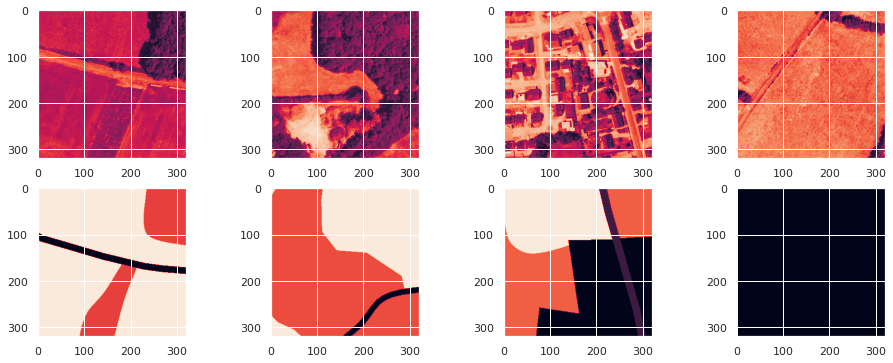

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(16,6))
idx = np.random.choice(len(site_1_X), 4)
for i in range(4):
    tileX, tileY = loadTiff(site_1_X[idx[i]], site_1_Y[idx[i]])
    patchX, patchY = patchify(tileX, tileY, 320)
    axs[0, i].imshow(patchX[10, :, :, 0])
    axs[1, i].imshow(patchY[10, :, :])

## Define SegNet Architecture

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape, Dropout


def build_FCN(nrows, ncols, nbands, NUMBER_CLASSES):
    """Function to create Keras model of sample network."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(7, 7),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
              pool_size=(3, 3),
              strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(keras.layers.Conv2D(
              filters=NUMBER_CLASSES,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    #model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

In [10]:
model = build_FCN(320, 320, 3, 15)

2022-01-07 15:33:58.935187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/opt/hadoop/lib/native:/usr/local/lib/R/lib:/usr/local/grass78/lib
2022-01-07 15:33:58.936336: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# MAML

In [ ]:
from tqdm import tqdm
from collections import defaultdict

inner_optimizer = tf.keras.optimizers.Adam()
outer_optimizer = tf.keras.optimizers.Adam()
cce = tf.keras.losses.SparseCategoricalCrossentropy()

trained_idx = defaultdict(list)

for i in tqdm(range(50)):

    model_weights = model.get_weights()
    task_weights = []
    query_sets_X, query_sets_Y = [], []
    batch_loss, batch_acc = [], []
    
    for task in range(5):
        site = np.random.choice([0, 1])
        
        if site==0:
            untrained_idx = np.arange(len(site_1_X))[np.logical_not(np.in1d(np.arange(len(site_1_X)), trained_idx[site]))]
            idx = np.random.choice(untrained_idx)
            tileX, tileY = loadTiff(site_1_X[idx], site_1_Y[idx])
        else:
            untrained_idx = np.arange(len(site_2_X))[np.logical_not(np.in1d(np.arange(len(site_2_X)), trained_idx[site]))]
            idx = np.random.choice(untrained_idx)
            tileX, tileY = loadTiff(site_2_X[idx], site_2_Y[idx])
        
        patchX, patchY = patchify(tileX, tileY, 320)
        trained_idx[site].append(idx)
        
        # Generate Support Set X
        support_idx = np.random.choice(range(patchX.shape[0]), size=3*patchX.shape[0]//4)
        support_set_X = patchX[support_idx]
        
        # Generate Query Set X
        query_set_X = patchX[np.delete(range(patchX.shape[0]), support_idx)]
        query_sets_X.append(query_set_X)
        
        # Generate Support Set Y
        support_set_Y = patchY[support_idx]
        support_set_Y = support_set_Y.astype(np.uint8)
        
        # Generate Query Set Y
        query_set_Y = patchY[np.delete(range(patchX.shape[0]), support_idx)]
        query_set_Y = query_set_Y.astype(np.uint8)
        query_sets_Y.append(query_set_Y)
    
        # Meta Train
        model.set_weights(model_weights)
        for batch in range(0, support_set_X.shape[0], 5):
            with tf.GradientTape() as train_tape:
                train_loss = cce(support_set_Y[batch:batch+5], model(support_set_X[batch:batch+5]))
                train_loss = tf.reduce_mean(train_loss)
            # Step 6
            gradients = train_tape.gradient(train_loss, model.trainable_variables)
            inner_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        task_weights.append(model.get_weights())
        
    # Meta Update
    with tf.GradientTape() as test_tape:
        for m in range(5):
            model.set_weights(task_weights[m])
            for batch in range(0, query_sets_Y[m].shape[0], 5):
                test_loss = cce(query_sets_Y[m][batch:batch+5], model(query_sets_X[m][batch:batch+5]))
                test_loss = tf.reduce_mean(test_loss)
                batch_loss.append(test_loss)
                acc = tf.cast(tf.argmax(model(query_sets_X[m][batch:batch+5]), axis=3) == np.squeeze(query_sets_Y[m][batch:batch+5], axis=3), tf.float32)
                acc = tf.reduce_mean(acc)
                batch_acc.append(acc)
                #print(acc)
        mean_acc = tf.reduce_mean(batch_acc)
        mean_loss = tf.reduce_mean(batch_loss)
        print(F"Average Accuracy on Query Sets {mean_acc}")
    model.set_weights(model_weights)
    gradients = test_tape.gradient(mean_loss, model.trainable_variables)
    outer_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    model.save(F"./models/model_{i}")
    np.save(F"trained_idx_{i}", trained_idx)

  0%|          | 0/50 [00:00<?, ?it/s]

Average Accuracy on Query Sets 0.6333062648773193


2022-01-07 15:38:49.268027: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/model_0/assets


  2%|▏         | 1/50 [04:52<3:58:58, 292.61s/it]

Average Accuracy on Query Sets 0.42246362566947937
INFO:tensorflow:Assets written to: ./models/model_1/assets


  4%|▍         | 2/50 [08:59<3:32:34, 265.71s/it]